<a href="https://colab.research.google.com/github/skywalker0803r/Ricky/blob/master/%E7%8E%89%E5%B1%B1AI%E6%AF%94%E8%B3%BD_modeling_lightgbm%E7%89%88%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import warnings 
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
中文map = {'bacno':'歸戶帳號','txkey':'交易序號','locdt':'授權日期','loctm':'授權時間','cano':'交易卡號',
         'contp':'交易類別','etymd':'交易型態','mchno':'特店代號','acqic':'收單行代碼','mcc':'MCC_CODE',
         'conam':'交易金額-台幣(經過轉換)','ecfg':'網路交易註記','insfg':'分期交易註記','iterm':'分期期數',
         'stocn':'消費地國別','scity':'消費城市','stscd':'狀態碼','ovrlt':'超額註記碼','flbmk':'Fallback註記',
         'hcefg':'支付型態','csmcu':'消費地幣別','flg_3dsmk':'3DS交易註記','fraud_ind':'盜刷註記'}

# train

In [3]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/train_特徵工程完.csv",index_col=0)
print(train.shape)
train.head()

(1521787, 75)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,insfg,ovrlt,flg_3dsmk,csmcu,mchno,cano,mcc,flbmk,bacno,mchno_stscd_2_norm_count,acqic_stscd_2_norm_count,cano_stscd_2_norm_count,acqic_ecfg_0_norm_count,acqic_scity_nunique,acqic_csmcu_nunique,cano_stscd_nunique,acqic_etymd_8_norm_count,acqic_hcefg_nunique,bacno_stscd_nunique,acqic_ovrlt_0_norm_count,cano_ecfg_0_norm_count,acqic_etymd_5_norm_count,acqic_flbmk_nunique,acqic_loctm_nunique,acqic_stscd_nunique,mchno_ecfg_nunique,acqic_contp_nunique,mchno_csmcu_nunique,acqic_etymd_4_norm_count,cano_etymd_8_norm_count,mchno_stscd_nunique,acqic_etymd_6_norm_count,cano_stocn_nunique,mchno_etymd_5_norm_count,mchno_loctm_nunique,acqic_flg_3dsmk_1_norm_count,acqic_hcefg_9_norm_count,mchno_etymd_4_norm_count,cano_etymd_5_norm_count,mchno_ovrlt_0_norm_count,bacno_csmcu_nunique,acqic_contp_2_norm_count,acqic_contp_5_norm_count,mchno_hcefg_nunique,mchno_contp_nunique,cano_etymd_nunique,bacno_ecfg_nunique,bacno_cano_nunique,mchno_etymd_2_norm_count,acqic_etymd_2_norm_count,cano_etymd_4_norm_count,cano_conam_nunique,acqic_hcefg_7_norm_count,mchno_ovrlt_nunique,mchno_etymd_nunique,acqic_hcefg_8_norm_count,bacno_scity_nunique,mchno_stocn_nunique,mchno_etymd_7_norm_count,acqic_flbmk_1_norm_count,acqic_etymd_10_norm_count,acqic_etymd_7_norm_count,mchno_etymd_0_norm_count,txkey,fraud_ind
0,0,0,102,6862,0,61954,0,5,5,16158,0,0,0,0,59034,37846,457,0,112785,0.001044,0.001344,0.0,1.000000,1,2,1,0.000000,3,1,0.987376,0.712500,0.000000,2,56166,2,1,1,2,0.000000,0.000000,2,0.0,5,0.000000,30931,0.000000,0.000000,0.000000,0.287500,0.985317,3,0.000000,1.000000,3,1,5,2,1,0.000000,0.000000,0.125000,51,0.0,2,1,0.000000,13,1,0.0,0.000000,0.0,0.0,1.000000,516056,0
1,0,0,102,0,2,38216,5795,0,5,13693,0,0,0,0,0,45476,451,0,133951,0.000016,0.000000,0.0,1.000000,2,7,1,0.000000,6,1,0.991720,0.913043,0.000000,2,7858,4,2,3,4,0.000000,0.000000,3,0.0,1,0.049750,9926,0.000000,0.000000,0.028673,0.130435,0.992090,2,0.000000,0.997311,6,2,4,2,1,0.894976,0.929998,0.391304,16,0.0,2,7,0.003276,4,2,0.0,0.000000,0.0,0.0,0.024906,4376,0
2,0,0,102,6862,0,54640,0,5,5,16158,0,0,0,0,59034,187354,457,0,15350,0.001044,0.001344,0.0,1.000000,1,2,1,0.000000,3,1,0.987376,1.000000,0.000000,2,56166,2,1,1,2,0.000000,0.000000,2,0.0,1,0.000000,30931,0.000000,0.000000,0.000000,0.388889,0.985317,2,0.000000,1.000000,3,1,4,1,1,0.000000,0.000000,0.333333,12,0.0,2,1,0.000000,4,1,0.0,0.000000,0.0,0.0,1.000000,483434,0
3,0,0,102,6697,5,62128,3267,5,5,40413,0,0,0,62,50185,29812,247,0,156492,0.000000,0.000149,0.0,0.764562,101,2,1,0.142619,9,1,0.988238,0.964912,0.312315,3,63329,3,1,5,1,0.304452,0.000000,1,0.0,1,0.455809,991,0.038519,0.000482,0.525323,0.421053,0.987090,1,0.008969,0.940821,3,2,4,2,2,0.009930,0.223049,0.315789,48,0.0,2,5,0.003765,9,1,0.0,0.004572,0.0,0.0,0.000000,1407164,0
4,0,0,102,5959,4,65231,5795,5,5,25962,0,0,0,62,93290,80881,263,0,105534,0.000000,0.000038,0.0,0.916687,34,2,1,0.077908,7,1,0.990016,0.761905,0.206081,3,59086,3,1,4,1,0.447080,0.238095,1,0.0,1,0.000000,48,0.044159,0.000094,1.000000,0.206349,1.000000,2,0.158531,0.834675,1,1,5,2,2,0.000000,0.242426,0.111111,35,0.0,1,1,0.000857,8,1,0.0,0.000507,0.0,0.0,0.000000,1051004,0


# test

In [4]:
test = pd.read_csv("/content/drive/My Drive/玉山人工智慧比賽數據/test_特徵工程完.csv",index_col=0)
test_txkey = test["txkey"]
print(test.shape)
test.head()

(421665, 74)


,stscd,ecfg,stocn,acqic,etymd,loctm,scity,hcefg,contp,conam,insfg,ovrlt,flg_3dsmk,csmcu,mchno,cano,mcc,flbmk,bacno,mchno_stscd_2_norm_count,acqic_stscd_2_norm_count,cano_stscd_2_norm_count,acqic_ecfg_0_norm_count,acqic_scity_nunique,acqic_csmcu_nunique,cano_stscd_nunique,acqic_etymd_8_norm_count,acqic_hcefg_nunique,bacno_stscd_nunique,acqic_ovrlt_0_norm_count,cano_ecfg_0_norm_count,acqic_etymd_5_norm_count,acqic_flbmk_nunique,acqic_loctm_nunique,acqic_stscd_nunique,mchno_ecfg_nunique,acqic_contp_nunique,mchno_csmcu_nunique,acqic_etymd_4_norm_count,cano_etymd_8_norm_count,mchno_stscd_nunique,acqic_etymd_6_norm_count,cano_stocn_nunique,mchno_etymd_5_norm_count,mchno_loctm_nunique,acqic_flg_3dsmk_1_norm_count,acqic_hcefg_9_norm_count,mchno_etymd_4_norm_count,cano_etymd_5_norm_count,mchno_ovrlt_0_norm_count,bacno_csmcu_nunique,acqic_contp_2_norm_count,acqic_contp_5_norm_count,mchno_hcefg_nunique,mchno_contp_nunique,cano_etymd_nunique,bacno_ecfg_nunique,bacno_cano_nunique,mchno_etymd_2_norm_count,acqic_etymd_2_norm_count,cano_etymd_4_norm_count,cano_conam_nunique,acqic_hcefg_7_norm_count,mchno_ovrlt_nunique,mchno_etymd_nunique,acqic_hcefg_8_norm_count,bacno_scity_nunique,mchno_stocn_nunique,mchno_etymd_7_norm_count,acqic_flbmk_1_norm_count,acqic_etymd_10_norm_count,acqic_etymd_7_norm_count,mchno_etymd_0_norm_count,txkey
1521787,0,0,102,6862,0,77950,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,0.001344,0.181818,1.0,1,2,2,0.0,3,2,0.987376,1.0,0.0,2,56166,2,1,1,2,0.0,0.0,2,0.0,1,0.0,4971,0.0,0.0,0.0,0.0,0.97819,1,0.0,1.0,3,1,1,1,1,0.0,0.0,0.0,1,0.0,2,1,0.0,1,1,0.0,0.0,0.0,0.0,1.0,592489
1521788,0,0,102,6862,0,79549,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,0.001344,0.181818,1.0,1,2,2,0.0,3,2,0.987376,1.0,0.0,2,56166,2,1,1,2,0.0,0.0,2,0.0,1,0.0,4971,0.0,0.0,0.0,0.0,0.97819,1,0.0,1.0,3,1,1,1,1,0.0,0.0,0.0,1,0.0,2,1,0.0,1,1,0.0,0.0,0.0,0.0,1.0,592452
1521789,0,0,102,6862,0,60355,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,0.001344,0.181818,1.0,1,2,2,0.0,3,2,0.987376,1.0,0.0,2,56166,2,1,1,2,0.0,0.0,2,0.0,1,0.0,4971,0.0,0.0,0.0,0.0,0.97819,1,0.0,1.0,3,1,1,1,1,0.0,0.0,0.0,1,0.0,2,1,0.0,1,1,0.0,0.0,0.0,0.0,1.0,590212
1521790,0,0,102,6862,0,60296,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,0.001344,0.181818,1.0,1,2,2,0.0,3,2,0.987376,1.0,0.0,2,56166,2,1,1,2,0.0,0.0,2,0.0,1,0.0,4971,0.0,0.0,0.0,0.0,0.97819,1,0.0,1.0,3,1,1,1,1,0.0,0.0,0.0,1,0.0,2,1,0.0,1,1,0.0,0.0,0.0,0.0,1.0,590209
1521791,0,0,102,6862,0,77933,0,5,5,16158,0,0,0,0,59060,116168,457,0,162489,0.00193,0.001344,0.181818,1.0,1,2,2,0.0,3,2,0.987376,1.0,0.0,2,56166,2,1,1,2,0.0,0.0,2,0.0,1,0.0,4971,0.0,0.0,0.0,0.0,0.97819,1,0.0,1.0,3,1,1,1,1,0.0,0.0,0.0,1,0.0,2,1,0.0,1,1,0.0,0.0,0.0,0.0,1.0,592488


# 定義 features & cat_features & target

In [5]:
# 全部特徵
features = train.drop(['fraud_ind', # just target
                       'txkey', # just like index
                       ],axis=1).columns.tolist()

# 原始特徵才是cat_features
cat_features = sorted(list(set(features)&set(中文map.keys())))

y_name = 'fraud_ind'

print(len(features),features)
print(len(cat_features),cat_features)
print(len([y_name]),[y_name])

73 ['stscd', 'ecfg', 'stocn', 'acqic', 'etymd', 'loctm', 'scity', 'hcefg', 'contp', 'conam', 'insfg', 'ovrlt', 'flg_3dsmk', 'csmcu', 'mchno', 'cano', 'mcc', 'flbmk', 'bacno', 'mchno_stscd_2_norm_count', 'acqic_stscd_2_norm_count', 'cano_stscd_2_norm_count', 'acqic_ecfg_0_norm_count', 'acqic_scity_nunique', 'acqic_csmcu_nunique', 'cano_stscd_nunique', 'acqic_etymd_8_norm_count', 'acqic_hcefg_nunique', 'bacno_stscd_nunique', 'acqic_ovrlt_0_norm_count', 'cano_ecfg_0_norm_count', 'acqic_etymd_5_norm_count', 'acqic_flbmk_nunique', 'acqic_loctm_nunique', 'acqic_stscd_nunique', 'mchno_ecfg_nunique', 'acqic_contp_nunique', 'mchno_csmcu_nunique', 'acqic_etymd_4_norm_count', 'cano_etymd_8_norm_count', 'mchno_stscd_nunique', 'acqic_etymd_6_norm_count', 'cano_stocn_nunique', 'mchno_etymd_5_norm_count', 'mchno_loctm_nunique', 'acqic_flg_3dsmk_1_norm_count', 'acqic_hcefg_9_norm_count', 'mchno_etymd_4_norm_count', 'cano_etymd_5_norm_count', 'mchno_ovrlt_0_norm_count', 'bacno_csmcu_nunique', 'acqic_co

# both / test

In [7]:
f = {}
for col in cat_features:
  both_value = set(train[col].unique())&set(test[col].unique())
  f[col] = len(both_value)/len(test[col].unique())
res = pd.DataFrame(f,index=['both/test']).T.sort_values(by='both/test',ascending=False)
res['中文'] = res.index.map(中文map)
res

,both/test,中文
flg_3dsmk,1.000000,3DS交易註記
ecfg,1.000000,網路交易註記
ovrlt,1.000000,超額註記碼
insfg,1.000000,分期交易註記
flbmk,1.000000,Fallback註記
etymd,1.000000,交易型態
stscd,1.000000,狀態碼
contp,1.000000,交易類別
loctm,0.990267,授權時間
stocn,0.931034,消費地國別


# drop rare features

In [8]:
print(len(features))
try:
  features.remove('bacno')
  features.remove('cano')
except:
  pass
print(len(features))

73
71


In [9]:
print(len(cat_features))
try:
  cat_features.remove('bacno')
  cat_features.remove('cano')
except:
  pass
print(len(cat_features))

19
17


# 切分 train 跟 val

In [0]:
from sklearn.model_selection import KFold

kf = KFold(n_splits =5 ,random_state=42)
Folds = {}

for i,train_val_index in enumerate(kf.split(train.index)):
  Folds[i] = train_val_index

In [0]:
num_Fold = 0
train_index ,val_index = Folds[num_Fold]

In [0]:
val = train.loc[val_index,features+[y_name]]
train = train.loc[train_index,features+[y_name]]

# 切分 val_1,val_2

In [13]:
from sklearn.model_selection import train_test_split
val_1 ,val_2 = train_test_split(val[features+[y_name]] ,test_size=0.5 ,random_state=42)
print(train.shape)
print(val_1.shape)
print(val_2.shape)

(1217429, 72)
(152179, 72)
(152179, 72)


# 計算樣本權重

In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_org = train[y_name].append(val[y_name])

class_weight_dict = dict(zip([0,1],
                             compute_class_weight(class_weight ='balanced',
                                                  classes = np.unique(y_org),
                                                  y = y_org)))
class_weight_dict

{0: 0.5067785287645394, 1: 37.381159420289855}

人為調整一下

In [15]:
class_weight_dict = {
    0 : 1,
    1 : 2.5,
    }
class_weight_dict

{0: 1, 1: 2.5}

# scaler

In [0]:
num_feat = list(set(features)^set(cat_features))#全部特徵跟類別特徵的赤集

In [0]:
from sklearn.preprocessing import StandardScaler

# fit on full data
scaler =  StandardScaler().fit(train[num_feat].append(val[num_feat]).append(test[num_feat]))

# transform each data
train[num_feat] = scaler.transform(train[num_feat])
val_1[num_feat] = scaler.transform(val_1[num_feat])
val_2[num_feat] = scaler.transform(val_2[num_feat])
test[num_feat] = scaler.transform(test[num_feat])

In [20]:
import gc
gc.collect()

0

# sklearn配合GridSearch的版本 搜索較優超參數

In [0]:
import lightgbm
from sklearn.model_selection import GridSearchCV
import numpy as np

model_lgb = lightgbm.LGBMClassifier(objective = 'cross_entropy', # 分類
                                    metric = 'cross_entropy', # 分類
                                    #class_weight = 'balanced', # n_samples / (n_classes * np.bincount(y)).
                                    is_unbalance = True,
                                    max_depth = 7,
                                    num_leaves = 2**7-1,
                                    feature_fraction = 0.8,
                                    min_child_samples = 30,
                                    n_estimators = 100,
                                    )

#調過了
params_test1={
    'max_depth': range(3,7,2),#樹深度 best 7
    'num_leaves':range(7,127,30)#樹的葉子數量 best 2**7-1
    }

#調過了
params_test2={
    'feature_fraction': np.arange(0.5,1.0,0.1), #特徵選取比例 best 0.8
    'min_child_samples':range(10,60,10) #子節點最小樣本數 best 30
    }

#調n_estimators
params_test3={
    'n_estimators': np.arange(30,100,10),#best 100
    'max_depth': range(7,8,1),#樹深度 best 7
    }

# min_data_in_leaf 和 min_sum_hessian_in_leaf
params_test4={
    'min_child_samples': [19, 20, 21],
    'min_child_weight': [0.001, 0.002]
    }

gsearch = GridSearchCV(estimator = model_lgb,
                        param_grid = params_test4,
                        scoring = 'f1', #評分指標
                        cv = 3, #交叉驗證次數
                        verbose = 10,
                        n_jobs = -1,
                        return_train_score = True,
                        )

gsearch.fit(train[features],train[y_name])

# grid search結果

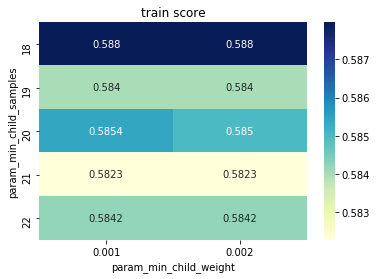

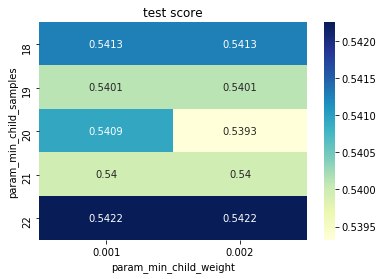

In [0]:
df_gridsearch = pd.DataFrame(gsearch.cv_results_)
max_scores = df_gridsearch.groupby(['param_min_child_samples','param_min_child_weight']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g',cmap='YlGnBu');
plt.title('train score')
plt.show()

sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g',cmap='YlGnBu');
plt.title('test score')
plt.show()

# 套用上面找出的較佳超參數 train model

In [23]:
print('cat_features:',cat_features)

['acqic', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd', 'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd']


[1]	train's xentropy: 0.0517875	train's f1: 0	val_1's xentropy: 0.0530849	val_1's f1: 0
Training until validation scores don't improve for 40 rounds.
[2]	train's xentropy: 0.0485221	train's f1: 0	val_1's xentropy: 0.0497723	val_1's f1: 0
[3]	train's xentropy: 0.0459235	train's f1: 0.000123495	val_1's xentropy: 0.0472097	val_1's f1: 0
[4]	train's xentropy: 0.043933	train's f1: 0.000246975	val_1's xentropy: 0.0452155	val_1's f1: 0
[5]	train's xentropy: 0.0422442	train's f1: 0.0072602	val_1's xentropy: 0.0435139	val_1's f1: 0.00863724
[6]	train's xentropy: 0.040745	train's f1: 0.0991329	val_1's xentropy: 0.0420764	val_1's f1: 0.0829876
[7]	train's xentropy: 0.0394252	train's f1: 0.126722	val_1's xentropy: 0.0408007	val_1's f1: 0.113225
[8]	train's xentropy: 0.0381977	train's f1: 0.166113	val_1's xentropy: 0.0395847	val_1's f1: 0.166227
[9]	train's xentropy: 0.0371078	train's f1: 0.202828	val_1's xentropy: 0.0385391	val_1's f1: 0.204974
[10]	train's xentropy: 0.0362011	train's f1: 0.266568

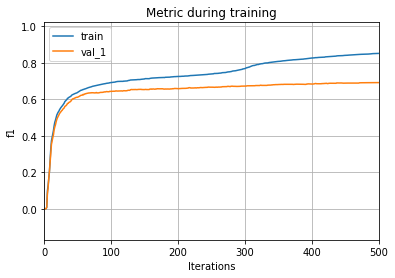

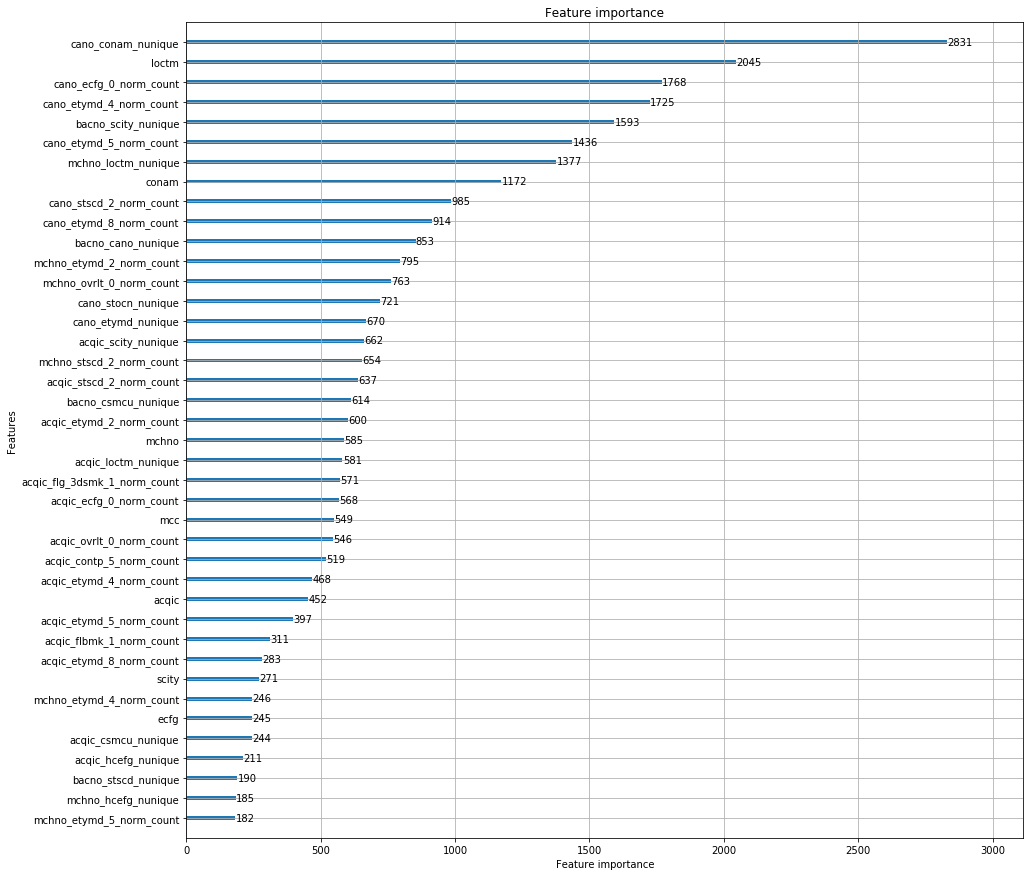

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.834977 to fit


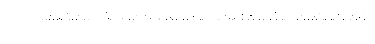

In [24]:
from sklearn.metrics import f1_score
import lightgbm
import numpy as np

# f1 score
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

# 定義超參數  
parameters = {
    'boosting_type':'gbdt',
    'objective': 'cross_entropy',
    'metric': 'cross_entropy',
    'num_iterations': 100*5,
    'learning_rate': 0.1/2,
    'max_depth': 7,
    'num_leaves': 2**7-1,
    'feature_fraction': 0.8,
    'tree_learner': 'data', #加速
    "is_unbalance": True, #不平衡
    "early_stopping_round": 40,
    'min_child_samples': 30,
    'min_child_weight': 0.002,
    }

# train data
train_data = lightgbm.Dataset(train[features],label=train[y_name],
                              categorical_feature = cat_features)

# val_1_data
val_1_data = lightgbm.Dataset(val_1[features],label=val_1[y_name],
                              categorical_feature = cat_features)

# model training
evals_result = {}
model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=[val_1_data, train_data],
                       valid_names=['val_1','train'], 
                       feval=lgb_f1_score,
                       evals_result=evals_result,
                       )

# plt f1 metric
try:
  lightgbm.plot_metric(evals_result, metric='f1')
  plt.show()
except:
  pass

# plt features importance & save
try:
  ax = lightgbm.plot_importance(model, max_num_features=40, figsize=(15,15))
  plt.savefig("./features_importances.png")
  plt.show()
except:
  pass

# plt tree
try:
  ax = lightgbm.plot_tree(model,tree_index=3)
  plt.show()
except:
  pass

# plt tree_digraph
try:
  graph = lightgbm.create_tree_digraph(model,tree_index=3)
  graph.render(view=True)
except:
  pass

# val_2's F1 report

In [25]:
from sklearn.metrics import classification_report 

val_2_pred_01 = pd.Series(model.predict(val_2[features])).apply(round)

print(classification_report(val_2[y_name],val_2_pred_01,target_names=['0','1']))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00    150093
           1       0.83      0.57      0.68      2086

    accuracy                           0.99    152179
   macro avg       0.91      0.79      0.84    152179
weighted avg       0.99      0.99      0.99    152179



# 產生submission

In [26]:
submission = pd.DataFrame({"txkey":test_txkey,
                           "fraud_ind":model.predict(test[features])})


# to [0,1] 
submission["fraud_ind"] = submission["fraud_ind"].apply(round)

# value_counts
print(submission["fraud_ind"].value_counts())
submission.head()

0    416948
1      4717
Name: fraud_ind, dtype: int64


,txkey,fraud_ind
1521787,592489,0
1521788,592452,0
1521789,590212,0
1521790,590209,0
1521791,592488,0


# 這裡有個想法如果test上盜刷的比例 跟train上面盜刷的比例 愈相近愈好

In [27]:
train_p = round((train['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(train['fraud_ind']))*100 ,5) #總數

val_1_p = round((val_1['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_1['fraud_ind']))*100 ,5) #總數

val_2_p = round((val_2['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(val_2['fraud_ind']))*100 ,5) #總數

test_p = round((submission['fraud_ind'].value_counts()[1] / #盜刷樣本數
                len(submission['fraud_ind']))*100 ,5) #總數
pd.DataFrame({'train_p':train_p,
              'val_1_p':val_1_p,
              'val_2_p':val_2_p,
              'test_p':test_p},
               index=['盜刷比例%'])

,train_p,val_1_p,val_2_p,test_p
盜刷比例%,1.33018,1.36353,1.37075,1.11866


# 保存預測結果

In [0]:
submission.to_csv("./submission_lightgbm_Fold_0.csv")

In [29]:
print(submission["fraud_ind"].value_counts())

0    416948
1      4717
Name: fraud_ind, dtype: int64
